In [1]:
%load_ext autoreload
%autoreload 2

import copy
import numpy as np
import isambard
import tempfile

# for visualisation of moelcules
import nglview

## Utilities & Definitions 

In [2]:
def fix_PDB_element_column(PDB_file):
    """
    Some modelling packages do not write the element column in the PDB. 
    This function returns a fixed PDB string with correct values for the element column. 

    Assigns each atom's element based on the atom name field.
    Rules specified in the format specification:
        - Alignment of one-letter atom name such as C starts at column 14,
          while two-letter atom name such as FE starts at column 13.
        - Atom nomenclature begins with atom type.
    adapted from : https://github.com/haddocking/pdb-tools/blob/master/pdbtools/pdb_element.py
    """
    def pad_line(line):
        """
        Helper function to pad line to 80 characters in case it is shorter
        """
        size_of_line = len(line)
        if size_of_line < 80:
            padding = 80 - size_of_line + 1
            line = line.strip('\n') + ' ' * padding + '\n'
        return line[:81]  # 80 + newline character

    elements = set(
        ('H', 'D', 'HE', 'LI', 'BE', 'B', 'C', 'N', 'O', 'F', 'NE', 'NA', 'MG',
         'AL', 'SI', 'P', 'S', 'CL', 'AR', 'K', 'CA', 'SC', 'TI', 'V', 'CR',
         'MN', 'FE', 'CO', 'NI', 'CU', 'ZN', 'GA', 'GE', 'AS', 'SE', 'BR',
         'KR', 'RB', 'SR', 'Y', 'ZR', 'NB', 'MO', 'TC', 'RU', 'RH', 'PD', 'AG',
         'CD', 'IN', 'SN', 'SB', 'TE', 'I', 'XE', 'CS', 'BA', 'LA', 'CE', 'PR',
         'ND', 'PM', 'SM', 'EU', 'GD', 'TB', 'DY', 'HO', 'ER', 'TM', 'YB',
         'LU', 'HF', 'TA', 'W', 'RE', 'OS', 'IR', 'PT', 'AU', 'HG', 'TL', 'PB',
         'BI', 'PO', 'AT', 'RN', 'FR', 'RA', 'AC', 'TH', 'PA', 'U', 'NP', 'PU',
         'AM', 'CM', 'BK', 'CF', 'ES', 'FM', 'MD', 'NO', 'LR', 'RF', 'DB',
         'SG', 'BH', 'HS', 'MT'))
    records = ('ATOM', 'HETATM', 'ANISOU')
    ret = ''
    with open(PDB_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        line = pad_line(line.strip('\n'))
        if line.startswith(records):
            line = pad_line(line)
            atom_name = line[12:16]
            if atom_name[0].isalpha() and not atom_name[2:].isdigit():
                element = atom_name.strip()
            else:
                atom_name = atom_name.strip()
                if atom_name[0].isdigit():
                    element = atom_name[1]
                else:
                    element = atom_name[0]
            if element not in elements:
                element = '  '  # empty element in case we cannot assign
                print(
                    'fix_PDB_element_column(): WARNING, cannot assign element.'
                )
            line = line[:76] + element.rjust(2) + line[78:]
        ret += line + '\n'
    return ret


def visualise(mol):
    '''A helper function to visualise and ampal object in the notebook using nglview
    '''
    view = None
    with tempfile.NamedTemporaryFile(delete=True, suffix='.pdb') as tmp:
        tmp.write(mol.pdb.encode())
        tmp.seek(0) #Resets the buffer back to the first line
        view = nglview.show_file(tmp.name)
    return view


def get_coordinate_system(monomer):
    '''Caclulates the local coordinate system of a monomer of scapTet 
    Local coordinate system contains 3 orthogonal unit vectors representing the orientation of the monomer.
    
    Args:
        monomer (isambard.ampal.Assembly): Assembly object containing the scapTet 
    
    Returns:
        A tuple of 3 (np.ndarray) vectors (v24, v13, z) where  
            v24 extends from helix 2 to helix 4
            v13 extends from helix 1 to helix 3
            z = v24 cross v13
    '''
    start = np.sum([monomer[0][1:13].backbone.centre_of_mass,
                    monomer[0][44:56].backbone.centre_of_mass,
                    monomer[0][64:76].backbone.centre_of_mass,
                    monomer[0][108:122].backbone.centre_of_mass], axis=0)/4.
    end = np.sum([monomer[0][13:26].backbone.centre_of_mass,
                  monomer[0][32:44].backbone.centre_of_mass,
                  monomer[0][76:89].backbone.centre_of_mass,
                  monomer[0][95:108].backbone.centre_of_mass], axis=0)/4.
    z=end-start
    z/=np.linalg.norm(z)
    
    v13 = monomer[0][1:26].backbone.centre_of_mass - monomer[0][64:89].backbone.centre_of_mass
    v24 = monomer[0][32:56].backbone.centre_of_mass - monomer[0][95:122].backbone.centre_of_mass
    v13 -= np.dot(v13,z)*z
    v24 -= np.dot(v24,z)*z
    v13 /= np.linalg.norm(v13)
    v24 /= np.linalg.norm(v24)
    
    return v24, v13, z  


class Monomer(isambard.ampal.Assembly):
    '''An object inhereted from the isambard.ampal.Assembly with two additional methods:
        - coordinat_sytem: (which is a property) and returns a local coordinate system of the Monomer
        - visualise(): visualises the Monomer
    '''
    def __init__(self, monomer):
        super().__init__()
        self._molecules = monomer._molecules
        self.id = monomer.id

    @property
    def coordinate_system(self):
        return get_coordinate_system(self)
    
    def visualise(self, coordinate_system=False):
        view = visualise(self)
        if coordinate_system:
            for v, name, color in zip(self.coordinate_system, 
                                      ['x', 'y', 'z'], 
                                      [[1,0,0], [0,1,0], [0,0,1]]
                                     ):
                view.shape.add_arrow([0,0,0], 5*v, color, 0.5, name)
        return view
    

class Dimer(isambard.ampal.Assembly):
    def __init__(self, monomer:Monomer, a=20, theta=0, phi1=0, phi2=0, z_shift=0, parallel=1):
        '''Constructs a dimer from monomer of type Monomer
        
        Args:
            - `monomer` (`Monomer`): the building block which is an instance of the `Monomer` class
            - `a` (`float`): radial separation between the two building blocks
            - `theta` (`float`): rotation angle of the second block with respect to the first one in the xy-plane 
            - `phi1` (`float`): twist angle (i.e. rotation around z-axis) of the first building block in degrees
            - `phi1` (`float`): twist angle (i.e. rotation around z-axis) of the second building block in degrees
            - `z_shift` (`float`): relative shift of the two building blocks in the z direction
            - `parallel` (`int`): can either be 1 (parallel) or -1 (anti-parallel)   
        '''
        super().__init__()
        
        self.a=a
        self.theta=theta
        self.phi1=phi1
        self.phi2=phi2
        self.z_shift=z_shift
        self.parallel=parallel
        
        m1 = copy.deepcopy(monomer)
        m2 = copy.deepcopy(monomer)

        assert parallel in [1, -1], "'parallel' must be in [-1, 1]." 
        if parallel==-1:
            m2.rotate(axis=m2.coordinate_system[0], angle=180, point=m2.centre_of_mass)
        
        m1.rotate(angle=self.phi1, axis=m1.coordinate_system[2])
        m2.rotate(angle=self.phi2, axis=m2.coordinate_system[2])
        T = np.array([self.a*np.cos(self.theta/180*np.pi),  
                      self.a*np.sin(self.theta/180*np.pi) , 
                      self.z_shift])
        m2.translate(T)
        
        
        self._molecules = (m1 + m2)._molecules
        self.id = f"dimer({m1.id})"
        self.relabel_all()
        for m in self._molecules:
            m.parent = self
            
    def visualise(self):
        return visualise(self)

# scapTet as the monomer
The building block of the dimer is a single-chain anti-parallel tetramer, which we store in the `Monomer` class (defined above). The monomer class adds a property to the `Assembly` object to return the local coordinate system of the building block. The local coordinate system is useful when we want to build a parametric model for the dimer.

We have used the `Monomer.visualise()` method with the option `coordinate_system=True` to visualise the monomer, and its local coordinate system (you'll need to install `nglview` to see this).

In [3]:
scapTet3_pdb_path = 'scapTet.pdb'
scapTet3 = isambard.ampal.load_pdb(scapTet3_pdb_path)
monomer = Monomer(scapTet3)
monomer.visualise(coordinate_system=True)

NGLWidget()

# Parametric model for the dimer
`Dimer` class builds a parametric model for the dimer with the following parameters:

- `monomer` (`Monomer`): the building block which is an instance of the `Monomer` class
- `a` (`float`): radial separation between the two building blocks
- `theta` (`float`): rotation angle of the second block with respect to the first one in the xy-plane 
- `phi1` (`float`): twist angle (i.e. rotation around z-axis) of the first building block in degrees
- `phi1` (`float`): twist angle (i.e. rotation around z-axis) of the second building block in degrees
- `z_shift` (`float`): relative shift of the two building blocks in the z direction
- `parallel` (`int`): can either be 1 (parallel) or -1 (anti-parallel)  

In [4]:
dimer = Dimer(monomer, a=20, theta=90, phi1=0, phi2=0, z_shift=0, parallel=1)
dimer.visualise()

NGLWidget()

In [5]:
dimer._molecules

[<Polypeptide containing 123 Residues. Sequence: GELEALAQELEA...>,
 <Polypeptide containing 123 Residues. Sequence: GELEALAQELEA...>]

# Choose a sequence and pack side-chains
Here, we choose the dimer sequence and pack the side chains around the rigid back-bone using [Scwrl4](http://dunbrack.fccc.edu/SCWRL3.php/). Since the sequence is not the same for the two monomers this model is *hetero-dimer*.

*Notes*
- I notices that on macOS the latest `Scwrl4` requires passing an additional argument `-p configuration_file`. This may cause `isambard.modelling.pack_side_chains_scwrl()` to fail. My hack to avoid this problem was:
    
```
scwrl_root=/Users/majid/scwrl4  # replace this path with the path to your own Scwrl4
cd $scwrl_root
mv Scwrl4 Scwrl4_
echo '#!/bin/bash' > Scwrl4
echo '/Users/majid/scwrl4/Scwrl4_ -p /Users/majid/scwrl4/Scwrl4.ini "$@"' >> Scwrl4
chmod +x Scwrl4
```
 
- You'll also need to add the `Scwrl4` path (i.e. `scwrl_root` above) to your PATH (see [here](https://stackoverflow.com/a/14638025))

- After successful packing of the side-chains, `dimer.tags` should contains the packing score in `key='scwrl_score'`.

In [6]:
sequences = ["""G ELEALAQ ELEALAQ KLKALAQ KLKAL    TSDS 
                Q ELEELAE ALEDLAE WLKELAQ KLKA     RARLD
                AQ ELEELAE ELEELAE WLKDLAQ KLKAL   TSDS
                Q ELEALAQ ELEALAE KLKALAQ KLKALAQ""",
             """G ELERLAA ELERLAK KLKALAQ KLKAL    TSDS
                Q ELEALAQ ELEALAE KLKALAQ KLKA     RARLD
                AQ ELEALAQ ELEALAQ KLKALAQ KLKAL   TSDS
                Q ELERLAR ELEKLAK KLKALAQ KLKALAQ"""]
sequences = [s.replace(" ", "").replace("\n", "") for s in sequences]
sequences

['GELEALAQELEALAQKLKALAQKLKALTSDSQELEELAEALEDLAEWLKELAQKLKARARLDAQELEELAEELEELAEWLKDLAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKALAQ',
 'GELERLAAELERLAKKLKALAQKLKALTSDSQELEALAQELEALAEKLKALAQKLKARARLDAQELEALAQELEALAQKLKALAQKLKALTSDSQELERLARELEKLAKKLKALAQKLKALAQ']

In [7]:
import isambard.modelling as modelling
dimer = modelling.pack_side_chains_scwrl(dimer, sequences=dimer.sequences, rigid_rotamer_model=False)
dimer.tags

{'scwrl_score': 2385.25}

# Optimise hetero-dimer parameters
Now we are ready to optimise the parameters of our parametric model by minimising the BUDE energy for the sequence chosen above.

In [8]:
import budeff
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
from functools import partial

def get_buff_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

specification = partial(Dimer, monomer=monomer)

## Define the search space
For each dynamic parameters, we specify their mean and the maximum variance around the mean.
For static parameters, we give their values.

In [9]:
parameters = [
    Parameter.static('monomer', monomer),
    Parameter.dynamic('a', 20, 5),
    Parameter.dynamic('theta', 45, 45),
    Parameter.dynamic('phi1', 0, 180),
    Parameter.dynamic('phi2', 0, 180),
    Parameter.static('z_shift', 0),
    Parameter.static('parallel', -1),
]

## Run optimisation
For demonstration, we run a very short search using genetic algorithm (`GA`). Note that with such a short search we cannot be sure if the minimum energy configuration found is a global one.

It seems that when using more than 1 core the optimisation will fail. I will see if I can fix this issue.

gen	evals	avg     	std    	min     	max     
0  	166  	-3834.86	55.3272	-3992.94	-3675.32
1  	136  	-3867.74	38.8855	-3997.3 	-3810.69
2  	116  	-3883.53	36.771 	-3997.3 	-3834.19
3  	133  	-3903.18	33.4773	-3999.33	-3858.72
4  	144  	-3912.15	26.7147	-4001.86	-3874.36
Evaluated 895 models in total in 5:00:15.417862
Best fitness is (-4001.8611295579008,)
Best parameters are [<Assembly (scapTet) containing 1 Polypeptide>, 21.969102410157863, 33.892486139547394, -151.72222148350951, -35.323784305678586, 0, -1]
----Minimisation plot:


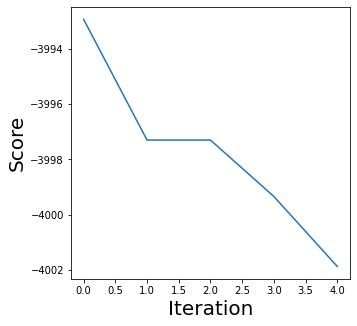

In [10]:
opt_ga = ev_opts.GA(Dimer, sequences, parameters, get_buff_total_energy)
opt_ga.run_opt(pop_size=200,
               generations=5,
               cores=1,
               plot=True)

In [11]:
best_dimer = opt_ga.best_model
best_idx = opt_ga.halloffame[0]
final_params = opt_ga.parse_individual(best_idx)
print(final_params)

[<Assembly (scapTet) containing 1 Polypeptide>, 21.969102410157863, 33.892486139547394, -151.72222148350951, -35.323784305678586, 0, -1]


In [12]:
# visualise a dimer (without packing side-chains)
Dimer(*final_params).visualise()

NGLWidget()

In [13]:
# Saving the best dimer PDB file
with open('best_dimer.pdb', 'w') as f:
    f.write(best_dimer.pdb)